In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# stationary or non
# dynamic or fixed
# multistep or unistep
# feature per company vs 1 feature

In [3]:
df = pd.read_csv('data/all_stocks_5yr.csv', header=0) #index_col=0)

In [4]:
df.shape

(619040, 7)

In [5]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [6]:
companies = pd.read_csv('data/InfoTechCompanies.csv') #index_col=0)
companies.shape

(68, 1)

In [7]:
companies_lst = companies.T.values.tolist()[0]
# filter the companies
company_filter = df['Name'].isin(companies_lst)
df = df[company_filter]
print(df.shape)
df.head()

(72056, 7)


,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [8]:
dates_selected = df[df['Name'] == 'AAPL']['date']

60


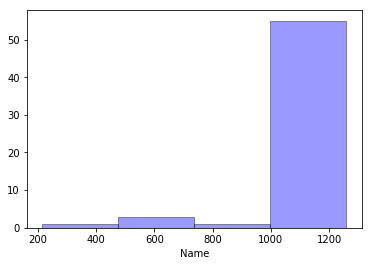

In [9]:
print(df['Name'].unique().size)
freqs = df['Name'].value_counts()
ax = sns.distplot(freqs, hist=True, kde=False, 
             bins=4, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [10]:
dates_num = len(df['date'].unique())
dates_num

1259

In [11]:
freqs_index = freqs[freqs == dates_num].index
freqs_filter = df['Name'].isin(freqs_index)
df = df[freqs_filter]

In [12]:
set(df.groupby('Name')['date'].count())

{1259}

In [55]:
print(len(df['Name'].unique()))

54


In [13]:
df.reset_index(drop=True, inplace=True)
print(df.shape)
print(df.head())

(67986, 7)
         date     open     high      low    close     volume  Name
0  2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL
1  2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL
2  2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL
3  2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL
4  2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL


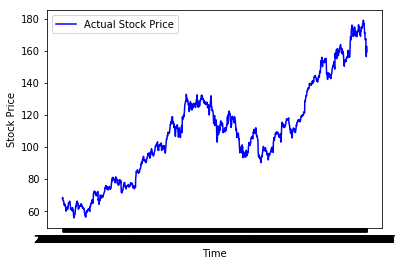

In [14]:
var2plot = 'AAPL'
x = df[df['Name']==var2plot]['date']
y = df[df['Name']==var2plot]['close']

plt.plot(x, y, color = 'blue', label = 'Actual Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

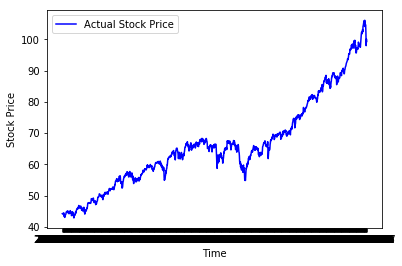

In [16]:
x = df[df['Name']==var2plot]['date']
y = df.groupby('date')['close'].mean()

plt.plot(x, y, color = 'blue', label = 'Actual Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
# convert time series into supervised learning problem
def df_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# transform series into train and test sets for supervised learning
def prepare_data(df, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = df.values
    # comment out for multivariate
    #raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = df_to_supervised(raw_values, n_lag, n_seq)
    #supervised_values = supervised.values
    # split into train and test sets
    #train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return supervised #train, test

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [27]:
# configure
n_lag = 1
n_seq = 1
n_test = 10
data = df
# prepare data
prep_data = prepare_data(data, n_test, n_lag, n_seq)
#print(test)
#print('Train: %s, Test: %s' % (train.shape, test.shape))
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [149]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [51]:
close_per_company = df.groupby('Name')['close']
df_company_features = pd.DataFrame()
for comp, data in close_per_company:
    df_tmp = pd.DataFrame(data.values,columns=[comp])
    df_company_features = pd.concat([df_company_features, df_tmp], axis=1)

In [53]:
df_company_features.shape

(1259, 54)